# Sensitivity analysis for non-parametric causal estimators
Sensitivity analysis helps us study how robust an estimated effect is when the assumption of no unobserved confounding is violated. That is, how much bias did we introduce in our estimate by omitting  an (unobserved) confounder? Known as the 
*omitted variable bias (OVB)*, it gives us a measure of how the inclusion of an omitted common cause (confounder) changes the estimated effect. 

This notebook shows how to estimate the OVB for general, non-parametric causal estimators. For gaining intuition, we suggest going through an introductory notebook that describes how to estimate OVB for a a linear estimator: [Sensitivity analysis for linear estimators](https://github.com/py-why/dowhy/blob/master/docs/source/example_notebooks/sensitivity_analysis_testing.ipynb). To recap, in that notebook, we saw how the OVB depended on linear partial R^2 values and used this insight to compute the adjusted estimate values depending on the relative strength of the confounder with the outcome and treatment. We now generalize the technique using the non-parametric partial R^2 and Reisz representers.<br>


### Key definitions
**Non-parametric R^2**: When the conditional expectation function is not linear, the strength of association between the confounder U and outcome Y, treatment T can be measured by Pearson's nonparametric R^2.

### Summary of the method

For more details, refer to Chernozhukov et al. Long Story Short: Omitted Variable Bias in Causal Machine Learning.  https://arxiv.org/abs/2112.13398. 


We see that the bound on the bias depends on the non parametric partial R^2 of the unobserved confounders with outcome (r2yu_tw) and treatment (r2tu_w). <br>
Partial R^2 of outcome Y with confounder U given treatment T and common causes W is given by <br>
R2yu_tw = ( R2y_utw - R2y_tw) / ( 1 - R2y_tw ) <br>
Similarly, R2tu_w = ( R2t_uw - R2t_w ) / ( 1 - R2t_w ) <br>

AddUnobservedCommonCause class supports three methods:
1) Simulation based <br>
2) Linear partial R2 based : Sensitivity Analysis for linear models.<br>
3) Non-Parametric partial R2 based : Sensitivity Analyis for non-parametric models. Two important quantities used to estimate the bias are alpha and g<br> <br>
g := E[Y | T, W, Z] denotes the long regression function<br>
g_s := E[Y | T, W] denotes the short regression function<br>
α := (T - E[T | W, Z] ) / (E(T - E[T | W, Z]) ^ 2) denotes long reisz representer<br>
α_s := (T - E[T | W] ) / (E(T - E[T | W]) ^ 2) denotes short reisz representer<br> <br>
Bias = E(g_s - g)(α_s - α) for partially linear models<br>
Thus, The bound is the product of additional variations that omitted confounders generate in the regression function and in the reisz representer for partially linear models.<br>
Whereas for non parametric models, Bias = S * Cg * Calpha <br>
where Cg and Calpha are explanatory powers of the confounder where 
- Cg^2 = r2yu_tw
- Calpha^2 = r2tu_w / (1 - r2tu_w
- S^2 = E(Y - g_s) ^ 2 * E(α_s ^ 2) <br>

## Step 1: Load required packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Required libraries
import re
import numpy as np
import dowhy
from dowhy import CausalModel
import dowhy.datasets
from dowhy.utils.util import create_polynomial_function

### Step 2: Load the dataset 
We create a dataset with linear relationships between common causes and treatment, and common causes and outcome. Beta is the true causal effect.

In [3]:
np.random.seed(101) 
data = dowhy.datasets.partially_linear_dataset(beta = 10,
                                               num_common_causes = 7,
                                               num_unobserved_common_causes=1,
                                               strength_unobserved_confounding=10,
                                               num_samples = 500,
                                               num_treatments = 1,
                                               stddev_treatment_noise = 10,
                                               stddev_outcome_noise = 5
                                                )
display(data)

{'df':            W0        W1        W2        W3        W4        W5        W6  \
 0    0.345542  0.696984 -0.708658 -1.997165 -0.709139  0.165913 -0.554212   
 1   -0.075270  1.652779 -0.259591  0.282963 -0.764418  0.032002 -0.360908   
 2   -0.240272 -0.174564 -0.934469 -0.451650  1.959730  1.201015  0.471282   
 3    0.119874 -0.256127  0.318636 -0.223625  0.233940  1.549934 -0.763879   
 4    0.179436  1.410457 -0.635170 -1.263762  1.289872 -0.528325  0.122878   
 ..        ...       ...       ...       ...       ...       ...       ...   
 495 -0.918275  0.413940 -2.771209 -0.113019 -0.461614  1.309347  0.387558   
 496  0.046074  1.635913 -2.067205  0.693155 -0.102939 -0.165906  0.548974   
 497 -0.657989 -2.221034 -0.692297 -1.357233  1.977781  1.676112 -0.224756   
 498  2.065935  0.336375 -0.083284 -1.107344  1.262738  1.673617  0.822227   
 499 -0.623183  1.915742 -0.299116 -1.374898  0.494912  0.764341 -1.833552   
 
         v0          y  
 0     True   1.480448  
 1    

In [4]:
np.corrcoef(data["df"]['W0'], data["df"]['y'])

array([[ 1.        , -0.08873682],
       [-0.08873682,  1.        ]])

The true ATE for this data-generating process is,

In [5]:
data["ate"]

To simulate unobserved confounding, we remove one of the common causes. 


In [6]:
# Observed data 
dropped_cols=["W0"]
user_data = data["df"].drop(dropped_cols, axis = 1)
# assumed graph
user_graph = data["gml_graph"]
for col in dropped_cols:
    user_graph = user_graph.replace('node[ id "{0}" label "{0}"]'.format(col), '')
    user_graph = re.sub('edge\[ source "{}" target "[vy][0]*"\]'.format(col), "", user_graph)
user_data

,W1,W2,W3,W4,W5,W6,v0,y
0,0.696984,-0.708658,-1.997165,-0.709139,0.165913,-0.554212,True,1.480448
1,1.652779,-0.259591,0.282963,-0.764418,0.032002,-0.360908,True,9.161068
2,-0.174564,-0.934469,-0.451650,1.959730,1.201015,0.471282,True,19.512323
3,-0.256127,0.318636,-0.223625,0.233940,1.549934,-0.763879,True,4.769235
4,1.410457,-0.635170,-1.263762,1.289872,-0.528325,0.122878,True,0.870015
...,...,...,...,...,...,...,...,...
495,0.413940,-2.771209,-0.113019,-0.461614,1.309347,0.387558,False,-1.485764
496,1.635913,-2.067205,0.693155,-0.102939,-0.165906,0.548974,True,17.585363
497,-2.221034,-0.692297,-1.357233,1.977781,1.676112,-0.224756,False,3.496803
498,0.336375,-0.083284,-1.107344,1.262738,1.673617,0.822227,True,6.299920


### Step 3: Create Causal Model
Create a causal model with the "observed" data and causal graph.

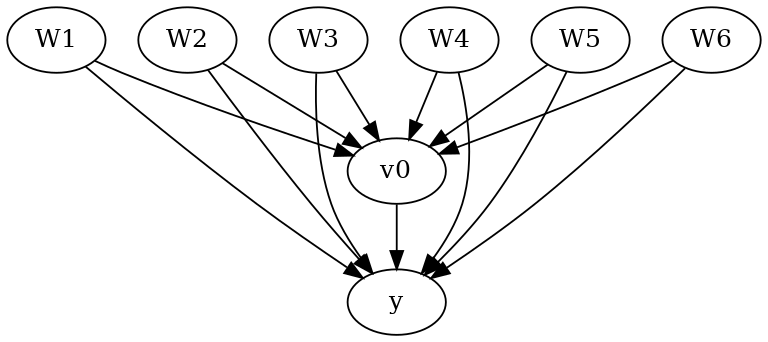

In [7]:
#graph_str = 'graph[directed 1node[ id "y" label "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id "W2" label "W2"] node[ id "W3" label "W3"]  node[ id "W5" label "W5"] node[ id "W6" label "W6"]node[ id "v0" label "v0"]edge[source "v0" target "y"]edge[ source "W0" target "v0"] edge[ source "W1" target "v0"] edge[ source "W2" target "v0"] edge[ source "W3" target "v0"] edge[ source "W5" target "v0"] edge[ source "W6" target "v0"]edge[ source "W0" target "y"] edge[ source "W1" target "y"] edge[ source "W2" target "y"] edge[ source "W3" target "y"] edge[ source "W5" target "y"] edge[ source "W6" target "y"]]'
model = CausalModel(
            data=user_data,
            treatment=data["treatment_name"],
            outcome=data["outcome_name"],
            graph=user_graph,
            test_significance=None,
        )
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

### Step 4: Identification

In [8]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                          
─────(E[y|W3,W5,W2,W6,W1,W4])
d[v₀]                        
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W5,W2,W6,W1,W4,U) = P(y|v0,W3,W5,W2,W6,W1,W4)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Step 5: Estimation

In [9]:
import econml
from sklearn.ensemble import GradientBoostingRegressor
estimate = model.estimate_effect(identified_estimand, 
                                    method_name="backdoor.econml.dml.KernelDML",
                                    method_params={
                                        'init_params': {'model_y':GradientBoostingRegressor(),
                                                        'model_t': GradientBoostingRegressor(),                                                       },
                                        'fit_params': {},#{'cache_values': True,}
                                     })
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                          
─────(E[y|W3,W5,W2,W6,W1,W4])
d[v₀]                        
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W5,W2,W6,W1,W4,U) = P(y|v0,W3,W5,W2,W6,W1,W4)

## Realized estimand
b: y~v0+W3+W5+W2+W6+W1+W4 | 
Target units: ate

## Estimate
Mean value: 6.413384618063163
Effect estimates: [6.41338462 6.41338462 6.41338462 6.41338462 6.41338462 6.41338462
 6.41338462 6.41338462 6.41338462 6.41338462 6.41338462 6.41338462
 6.41338462 6.41338462 6.41338462 6.41338462 6.41338462 6.41338462
 6.41338462 6.41338462 6.41338462 6.41338462 6.41338462 6.41338462
 6.41338462 6.41338462 6.41338462 6.41338462 6.41338462 6.41338462
 6.41338462 6.41338462 6.41338462 6.41338462 6.41338462 6.41338462
 6.41338462 6.41338462 6.41338462 6.41338462 6.41338462 6.41338462
 6.41338462 6.41338462 6.41338462 6.41338462 6.

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [10]:
estimate = model.estimate_effect(identified_estimand, 
                                    method_name="backdoor.linear_regression",
                                 )
print(estimate)

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                          
─────(E[y|W3,W5,W2,W6,W1,W4])
d[v₀]                        
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W5,W2,W6,W1,W4,U) = P(y|v0,W3,W5,W2,W6,W1,W4)

## Realized estimand
b: y~v0+W3+W5+W2+W6+W1+W4
Target units: ate

## Estimate
Mean value: 7.904233656550112



### Step 6: Refutation and Sensitivity Analysis
After estimation , we need to check how robust our estimate is against the possibility of unobserved confounders. This can be done using sensitivity analysis. We perform non parametric sensitivity analysis since we do not assume the data to be linearly generated.Non parametric models make no assumption about the mapping function or distribution of the data.
- <b>identified_estimand</b>: An instance of the identifiedEstimand class that provides the information with respect to which causal pathways are employed when the treatment effects the outcome<br>
- <b>estimate</b>: An instance of CausalEstimate class. The estimate obtained from the estimator for the original data.<br>
- <b>method_name</b>: Refutation method name <br>
- <b>simulated_method_name</b>: "non-parametric-partial-R2" for Non Parametric Sensitivity Analysis<br>
- <b>num_splits</b>: number of splits for cross validation. (default = 5) <br>
- <b>shuffle_data</b> : shuffle data or not before splitting into folds (default = False)<br>
- <b>shuffle_random_seed</b>: seed for randomly shuffling data<br>
- <b>alpha_s_param_dict</b>: dictionary with parameters for finding alpha_s: <br>
    - <b>reisz_functions</b>: List of polynomial functions of n degree to approximate reisz representer created using create_polynomial_function
    - <b>l2_regularizer</b>: l2 penalty while modeling (default = 1e-3)
    - For details of other parameters other parameters of ReiszRepresenter class see: https://econml.azurewebsites.net/_autosummary/econml.grf.CausalForest.html 
- <b>g_s_estimator_list</b>: list of estimator objects for finding g_s. Example: <br> 
[<br> RandomForestRegressor(n_estimators = 100, random_state = 120),<br> 
Pipeline([('scale', ColumnTransformer([('num', StandardScaler(), numeric_features)], remainder='passthrough')), ('lasso_model', Lasso())]),<br>
ReiszRegressor(regression_functions = create_polynomial_function(max_degree), min_var_leaf_on_val = True,min_impurity_decrease = 1e-4, max_samples = 0.80)<br>
]
- <b>g_s_estimator_param_list</b>: list of dictionaries with parameters for tuning respective estimators in g_s_estimator_list. Example: <br>
[ { 'n_estimators' : [50], 
    'max_depth' : [3, 4, 5],
    'min_samples_leaf' : [10,50]
  },<br>{'lasso_model__alpha' : [ 0.01, 0.001, 1e-4, 1e-5, 1e-6]},<br>
  {'regression_functions' : [create_polynomial_function(2), create_polynomial_function(4)],
   'min_samples_leaf' : [10, 50],
   'min_var_fraction_leaf' : [0.01, 0.1],
   'l2_regularizer' : [1e-2, 1e-3]
   }<br>
]
    - The parameters for ReiszRegressor
        - <b>regression_functions</b>: List of polynomial functions of n degree to approximate reisz regressor created using create_polynomial_function
        - <b>l2_regularizer</b>: l2 penalty while modeling (default = 1e-3)
        - For details of other parameters of ReiszRegressor class see: https://econml.azurewebsites.net/_autosummary/econml.grf.CausalForest.html 
- <b>benchmark_common_causes</b>: Name of the covariates used to bound the strengths of unobserved confounder<br>
- <b>effect_fraction_on_treatment</b>: Strength of association between unobserved confounder and treatment compared to benchmark covariate<br>
- <b>effect_fraction_on_outcome</b>: Strength of association between unobserved confounder and outcome compared to benchmark covariate<br>
- <b>plot_estimate</b>: Generate contour plot for estimate while performing sensitivity analysis. (default = True). To override the setting, set plot_estimate = False.

TypeError: from_bounds() takes 4 positional arguments but 6 were given

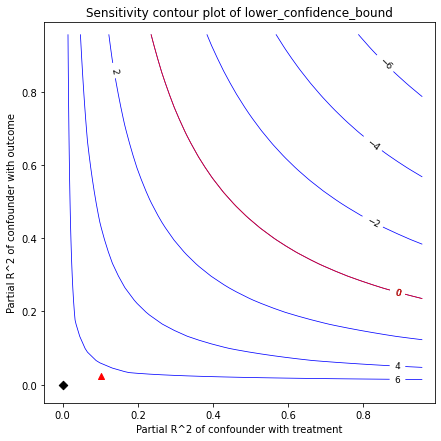

In [19]:
refute = model.refute_estimate(identified_estimand, estimate,
                               method_name = "add_unobserved_common_cause",
                               simulated_method_name = "non-parametric-partial-R2",
                               alpha_s_estimator_param_list =  None,
                               benchmark_common_causes = ["W1", "W2", "W3", "W4", "W5"],
                               effect_fraction_on_treatment = 0.2,
                               plugin_reisz=True
                              )
print(refute)


The x-axis shows (hypothetical) partial R^2 values of unobserved confounder(s) with the treatment. The y-axis shows hypothetical partial R^2 of unobserved confounder(s) with the outcome. At <x=0,y=0>, the black diamond shows the original estimate (theta_s) without considering the unobserved confounders.

The contour levels represent *adjusted* lower confidence bound estimate of the effect, which would be obtained if the unobserved confounder(s) had been included in the estimation model. The red contour line is the critical threshold where the adjusted effect goes to zero. Thus,  confounders with such strength or stronger are sufficient to reverse the sign of the estimated effect and invalidate the research conclusions.

The red triangle shows the estimated partial-R^2 of a chosen benchmark observed covariate with the treatment and outcome. In the above call, we chose *W3* as the benchmark covariate which has very low partial-R^2. Under the unobserved confounder cannot be stronger in its effect on treatment and outcome than the observed benchmark covariate (*W3*), the above plot shows that the mean estimated effect will stay above 8.92 even after accounting for unobserved confounding.

To verify, the true causal effect can be seen below. 

In [12]:
refute.S2

##### Parameter List for plot function
- <b>plot_type</b>: possible values are 'bias','lower_ate_bound','upper_ate_bound','lower_confidence_bound','upper_confidence_bound'<br>
- <b>x_limit</b>: plot's maximum x_axis value (default = 0.8) <br>
- <b>y_limit</b>: plot's minimum y_axis value (default = 0.8) <br>
- <b>num_points_per_contour</b>: number of points to calculate and plot each contour line (default = 200) <br>
- <b>plot_size</b>: tuple denoting the size of the plot (default = (7,7))<br>
- <b>contours_color</b>: color of contour line (default = blue)<br>
String or array. If array, lines will be plotted with the specific color in ascending order.<br>
- <b>critical_contour_color</b>: color of threshold line (default = red)<br>
- <b>label_fontsize</b>: fontsize for labelling contours (default = 9)<br>
- <b>contour_linewidths</b>: linewidths for contours (default = 0.75)<br>
- <b>contour_linestyles</b>: linestyles for contours (default = "solid") See : https://matplotlib.org/3.5.0/gallery/lines_bars_and_markers/linestyles.html<br>
- <b>contours_label_color</b>: color of contour line label (default = black)<br>
- <b>critical_label_color</b>: color of threshold line label (default = red)<br>
- <b>unadjusted_estimate_marker</b>: marker type for unadjusted estimate in the plot (default = 'D')
See: https://matplotlib.org/stable/api/markers_api.html <br>
- <b>unadjusted_estimate_color</b>: marker color for unadjusted estimate in the plot (default = "black")<br>
- <b>adjusted_estimate_marker</b>: marker type for bias adjusted estimates in the plot (default = '^')<br>
- <b>adjusted_estimate_color</b>: marker color for bias adjusted estimates in the plot (default = "red")<br>
- <b>legend_position</b>:tuple denoting the position of the legend (default = (1.6, 0.6))<br>

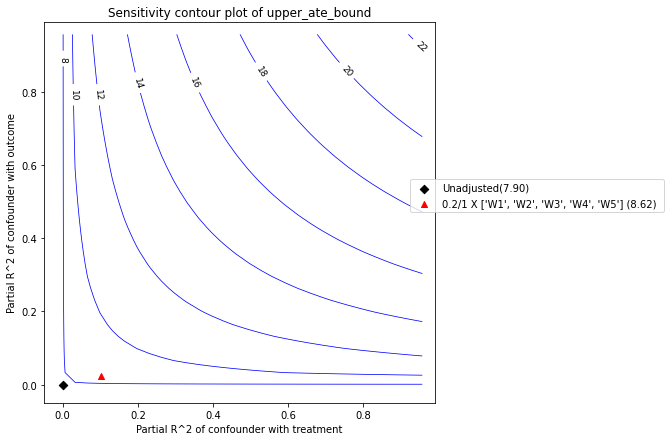

In [13]:
refute.plot(plot_type = "upper_ate_bound")

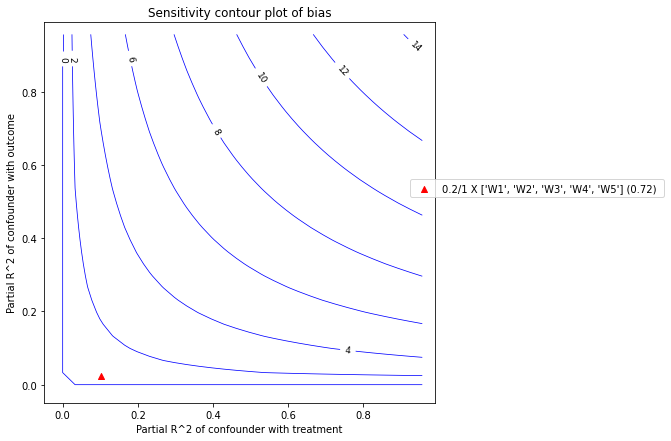

In [14]:
refute.plot(plot_type = "bias")

In [15]:
refute.results

,r2tu_w,r2yu_tw,short estimate,bias,lower_ate_bound,upper_ate_bound,lower_confidence_bound,upper_confidence_bound
0,0.102174,0.022486,7.904234,0.720097,7.184136,8.624331,6.424464,9.391736


In [16]:
print(refute)

Sensitivity Analysis to Unobserved Confounding using R^2 paramterization

Original Effect Estimate : 7.904233656550112
Robustness Value : 0.53

Robustness Value (alpha=0.05) : 0.48

Interpretation of results :
Any confounder explaining less than 53.0% percent of the residual variance of both the treatment and the outcome would not be strong enough to explain away the observed effect i.e bring down the estimate to 0 

For a significance level of 5.0%, any confounder explaining more than 48.0% percent of the residual variance of both the treatment and the outcome would be strong enough to make the estimated effect not 'statistically significant'




The robustness value measures the minimal equal strength of r2yu_tw and r2tu_w such the bound for the average treatment effect would include zero. It can be between 0 and 1.<br>
A low robustness value implies that the results can be changed even by the presence of weak confounders whereas a robustness value close to 1 means the treatment effect can handle strong confounders explaining  almost all residual variation of the treatment and the outcome.
A robustness value of 0.68 implies that confounders with r2yu_tw and r2tu_w values less than 0.68 would not be sufficient enough to bring down the estimates to zero.

## Sensitivity Analysis for Partially Linear Models
Partially Linear Models are where the conditional expectation functions (CEF) of the outcome are linearly separable in the treatment.<br>
Here, we perform partial sensitivity analysis for LinearDML estimator from econml. This method is computationally faster.<br>
The first four steps are common:<br>
1. Load Packages
2. Load Dataset
3. Create Causal Model
4. Identification

### Step 5: Estimation
Partial Linear Sensitivity Analysis is aperformed automatically if LinearDML estimator from econml is used for estimation.<br>
 Set <b>cache_values</b> = <b>True</b> in fit_params to cache the results of first stage estimation.

In [17]:
import econml
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, 
                                    method_name="backdoor.econml.dml.LinearDML",
                                    method_params={
                                        'init_params': {'model_y':GradientBoostingRegressor(),
                                                        'model_t': GradientBoostingRegressor(),
                                                        'linear_first_stages': False
                                                       },
                                        'fit_params': {'cache_values': True,}
                                     })

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [18]:
refute2 = model.refute_estimate(identified_estimand, dml_estimate ,
                               method_name = "add_unobserved_common_cause",
                               simulated_method_name = "non-parametric-partial-R2",
                               benchmark_common_causes = ["W1"],
                               effect_fraction_on_treatment = 0.05,
                                effect_fraction_on_ouctome = 0.04
                              )

AttributeError: 'AddUnobservedCommonCause' object has no attribute 'alpha_s_param_dict'

The x axis shows hypothetical partial R2 values of unobserved confounder(s) with the treatment. The y axis shows hypothetical partial R2 of unobserved confounder(s) with the outcome.<br>
The contour levels represent adjusted lower confidence bound for unobserved confounders with hypothetical partialR2 values when these would be included in full regression model. <br>
The black diamond shows the original estimate (theta_s) without considering the unobserved confounders<br>
The red line is the critical threshold: confounders with such strength or stronger are sufficient to invalidate the research conclusions.<br>

In [ ]:
refute2.results

In [ ]:
refute2.RV

The robustness value measures the minimal equal strength of r2yu_tw and r2tu_w such the bound for the average treatment effect would include zero. <br>
A robustness value of 0.4 implies that confounders with r2yu_tw and r2tu_w values less than 0.4 would not be sufficient enough to bring down the estimates to zero.

In [ ]:
print(refute2)